In [1]:
import sys
import os
from pathlib import Path

# Add project root to Python path to enable simcore imports
# The notebook is in simcore/examples/, so go up 2 levels to reach project root
project_root = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt

from simcore.network.graph import NetworkGraph, Node
from simcore.network.network import Network
from simcore.solver.integrate import run_sim_with_control
from simcore.components.dc_generator import DCGenerator
from simcore.components.motor_dc import MotorDCComponent




In [2]:
# ==========================================================
# PARAMETRI
# ==========================================================
dt = 0.01
t_stop = 30.0

# Obiettivo di corrente
i_ref = 8.0   # Ampere

# PI corrente
Kp = 2
Ki = 2
integral = 0.0


# ==========================================================
# TOPOLOGIA
# ==========================================================
bus = Node("bus")
gnd = Node("gnd", is_ground=True)

G = NetworkGraph()
G.add_branch("Gen", bus, gnd)
G.add_branch("Motor", bus, gnd)


# ==========================================================
# COMPONENTI
# ==========================================================
components = {
    "Gen": DCGenerator(V_nom=0.0, R_internal=0.02),
    "Motor": MotorDCComponent(
        R0=0.5,
        alpha=0.003,
        T0=293.0,
        L=2e-3,
        k_e=0.02,
        k_t=0.02,
        J=0.01,
        b=0.001,
        C_th=200.0,
        R_th=1.5,
        T_amb=293.0,
        i0=0.0,
        omega0=0.0,
        T0_state=293.0
    )
}

net = Network(G, components, dt=dt)

# Tensione iniziale
v0 = np.array([0.0])

# Stati iniziali (già concatenati)
z0 = net.z0.copy()

# Indice di base degli stati del motore
motor_base = net.stateful_indices[0]    # esempio → 0 o 1
# Corrente = z[motor_base + 0]
# Velocità = z[motor_base + 1]
# Temperatura = z[motor_base + 2]

from simcore.control.pi import PIController

def iref_callback(t):

    if t < 1.0:
        return 0
    elif t < 5.0:
        return 100
    else:
        return 50


controller = PIController(Kp, Ki, 0, 48, antiwindup=True)


# ==========================================================
# CALLBACK DI CONTROLLO
# ==========================================================
def control_callback(k, t, v_prev, z_prev, comps):

    i_motor = z_prev[motor_base + 0]   # estraggo corrente
    err = iref_callback(t) - i_motor
    V_cmd = controller.update(err, dt)

    comps["Gen"].V_nom = V_cmd



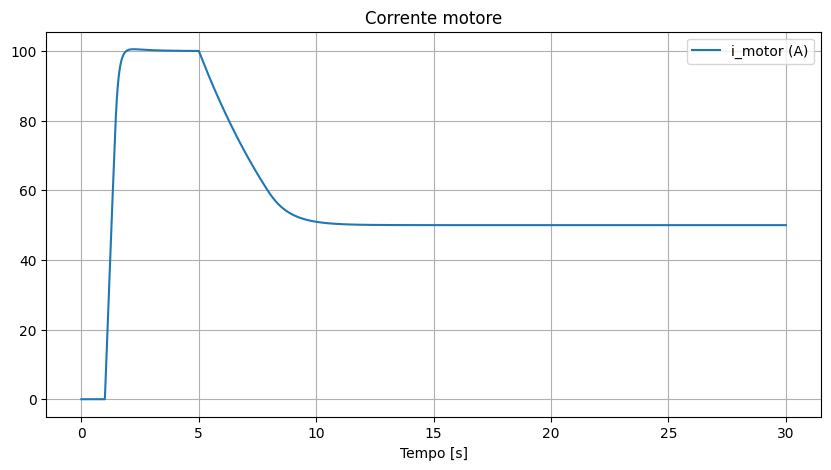

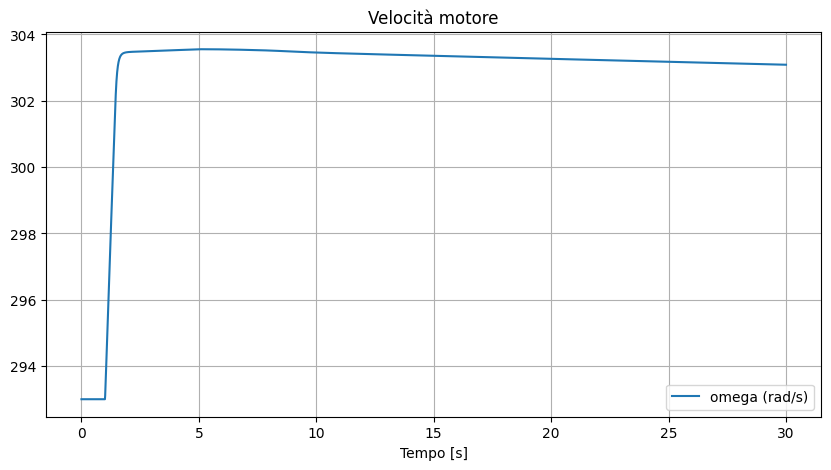

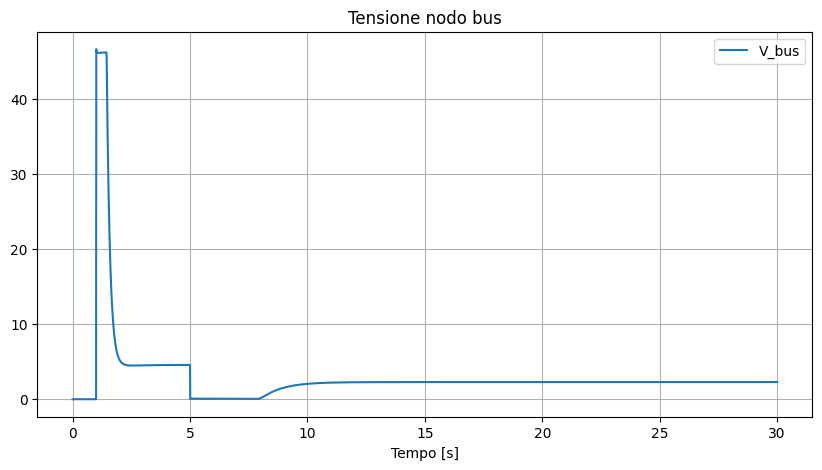

In [3]:

# ==========================================================
# ESECUZIONE SIMULAZIONE
# ==========================================================
result = run_sim_with_control(
    network=net,
    t_stop=t_stop,
    v0_nodes=v0,
    control_callback=control_callback
)

t = result.t
v_nodes = result.v_nodes[0]
z = result.z_hist

i_motor = z[:, motor_base + 0]
omega = z[:, motor_base + 1]

V_cmd_log = [components["Gen"].V_nom for _ in t]  # dopo callback l’ultimo valore rimane corretto


# ==========================================================
# PLOT RISULTATI
# ==========================================================
plt.figure(figsize=(10,5))
plt.plot(t, i_motor, label="i_motor (A)")
plt.grid(True); plt.legend(); plt.title("Corrente motore"); plt.xlabel("Tempo [s]")

plt.figure(figsize=(10,5))
plt.plot(t, omega, label="omega (rad/s)")
plt.grid(True); plt.legend(); plt.title("Velocità motore"); plt.xlabel("Tempo [s]")

plt.figure(figsize=(10,5))
plt.plot(t, v_nodes, label="V_bus")
plt.grid(True); plt.legend(); plt.title("Tensione nodo bus"); plt.xlabel("Tempo [s]")

plt.show()

